# Intro
Data can be found here [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html). Contains 102 flower categories.

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

In [1]:
import os
import json
import time
from collections import OrderedDict
from PIL import Image

import numpy as np

import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import models, transforms, datasets

import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Loading data

Load all data and transform train, valid and test sets appropriately. Most of the pretrained models requires images to be 224x224. We'll also need to load in a mapping from category label to category name

In [2]:
data_dir = 'flowers'
train_dir = f'{data_dir}/train'
valid_dir = f'{data_dir}/valid'
test_dir = f'{data_dir}/test'

image_names = os.listdir(f'{test_dir}/37')
print(image_names)

['image_03734.jpg', 'image_03741.jpg', 'image_03783.jpg', 'image_03789.jpg', 'image_03807.jpg', 'image_03811.jpg', 'image_03815.jpg', 'image_03821.jpg']


In [3]:
data_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(30),
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])
                                     ]),
    'valid': transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])
                                     ]),
    'test': transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])
                                    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                                  shuffle=True, num_workers=4)
                   for x in ['train', 'valid', 'test']}

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. We will use one of the pretrained models from `torchvision.models` (densenet201).

In [6]:
model = models.densenet201(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

C:\Users\miche\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [7]:
# create classifier with 102 output units, one for each flower type
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1920, 1000)),
    ('drop', nn.Dropout(p=0.5)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(1000, 500)),
    ('drop', nn.Dropout(p=0.5)),
    ('relu', nn.ReLU()),
    ('fc3', nn.Linear(500, 102)),
    ('output', nn.LogSoftmax(dim=1))
]))

model.classifier = classifier

In [8]:
# define optimizer and criterion
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0005)
exp_lr_scheduler = lr_scheduler.StepLR(
        optimizer, step_size=5, gamma=0.1)

In [14]:
# train network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(epochs=10):
    start = time.time()
    print(f'Training with {device}\n')

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch+1, epochs))
        print('-' * 20)

        for phase in ['train', 'valid']:
            if phase == 'train':
                exp_lr_scheduler.step()
                model.train()
                model.to(device)
            else:
                model.eval()

            running_error = 0.0
            running_corrects = 0

            for inputs, targets in dataloaders[phase]:
                inputs, targets = inputs.to(device), targets.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.forward(inputs)
                    _, predictions = torch.max(outputs, 1)
                    error = criterion(outputs, targets)

                    if phase == 'train':
                        error.backward()
                        optimizer.step()

                running_error += error.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == targets.data)

            epoch_error = running_error / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} Error: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_error, epoch_acc))
            print('-' * 20)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

In [27]:
epochs=5

In [15]:
train(epochs)

Training with cuda:0

Epoch 1/5
--------------------
train Error: 0.8943 Acc: 0.7663
--------------------
valid Error: 0.4674 Acc: 0.8851
--------------------
Epoch 2/5
--------------------
train Error: 0.7498 Acc: 0.7953
--------------------
valid Error: 0.3388 Acc: 0.9132
--------------------
Epoch 3/5
--------------------
train Error: 0.6048 Acc: 0.8361
--------------------
valid Error: 0.2761 Acc: 0.9389
--------------------
Epoch 4/5
--------------------
train Error: 0.5373 Acc: 0.8567
--------------------
valid Error: 0.2636 Acc: 0.9450
--------------------
Epoch 5/5
--------------------
train Error: 0.5273 Acc: 0.8591
--------------------
valid Error: 0.2527 Acc: 0.9450
--------------------
Training complete in 11m 15s


## Testing your network

Time for some testing. We will use images from flowers/test to test our model.

In [22]:
def validate():
    model.eval()
    model.to(device)
    accuracy = 0
    test_error = 0

    for inputs, targets in dataloaders['test']:
        inputs, targets = inputs.to(device), targets.to(device)

        with torch.no_grad():
            output = model.forward(inputs)
        test_error += criterion(output, targets).item()
        ps = torch.exp(output).data

        equality = (targets.data == ps.max(1)[1])
        if(torch.cuda.is_available()):
            accuracy += equality.type_as(torch.cuda.FloatTensor()).mean()
        else:
            accuracy += equality.type_as(torch.FloatTensor()).mean()

    print("Test Set")
    print("Test Set Error: {:.3f}".format(test_error/len(dataloaders['test'])))
    print("Test Set Accuracy: {:.3f}".format(accuracy/len(dataloaders['test'])))


In [23]:
validate()

Test Set
Test Set Error: 0.274
Test Set Accuracy: 0.931


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [25]:
# TODO: Save the checkpoint 
def save_checkpoint(state, filename='checkpoint.pth'):
    torch.save(state, filename)

In [30]:
# save index mapping/optimizer/epochs
save_checkpoint({
    'epoch': epochs,
    'arch': 'densenet201',
    'classifier': classifier,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'mapping': image_datasets['train'].class_to_idx
})

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [31]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    if os.path.isfile(filepath):
        print(f'Loading checkpoint {filepath}')
        checkpoint = torch.load(filepath)
        network = models.__dict__[checkpoint['arch']](pretrained=True)
        network.classifier = checkpoint['classifier']      
        optimizer.load_state_dict(checkpoint['optimizer'])
        network.load_state_dict(checkpoint['state_dict'])
        network.class_to_idx = checkpoint['mapping']
        
        return network

    else:
        print(f'No checkpoint found at: {filepath}')

In [34]:
loaded_network = load_checkpoint('checkpoint.pth')

Loading checkpoint checkpoint.pth


C:\Users\miche\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


# Inference for classification

Now we will write a function that takes an image and returns the top X most probable classes. But first we need a function that prepares tha image in way that our model can handle.

In [35]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''   
    image = Image.open(image).convert("RGB")
       
    in_transforms = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
    image = in_transforms(image)[:3,:,:]
    return image

In [36]:
def process_image2(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''   
    # open image and get size for x & y axis
    image = Image.open(image)
    image_x = int(image.size[0])
    image_y = int(image.size[1])
    
    # scale image ==> shortest side 256 and retain aspect_ratio
    aspect = float(image_x)/float(image_y)
    
    if(image_x > image_y):
        size_y = 256
        size_x = 256 * aspect
    elif(image_x < image_y):
        size_x = 256
        size_y = 256 * aspect
    else:
        size_x = 256
        size_y = 256
    
    image.thumbnail((size_x, size_y))
    
    # crop out center 224x224 portion of image
    left = (image.size[0] - 224)/2
    top = (image.size[1] - 224)/2
    right = (image.size[0] + 224)/2
    bottom = (image.size[0] + 224)/2
    
    image = image.crop((left, top, right, bottom)) 
    
    # change color channels from int to float and apply normalization
    np_image = np.asarray(image, dtype=np.float32) / 255
    np_image -= [0.485, 0.456, 0.406]
    np_image /= [0.229, 0.224, 0.225]

    # flip dimensions x, y, color to color, x, y
    np_image = np_image.transpose((2,0,1))
    print(np_image.shape)
    
    # return numpy.array as tensor
    return torch.from_numpy(np_image)

In [37]:
test_image = process_image(f'{test_dir}/37/image_03789.jpg')

In [38]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    image = image.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    if title: 
        ax.set_title(title)
    
    return ax

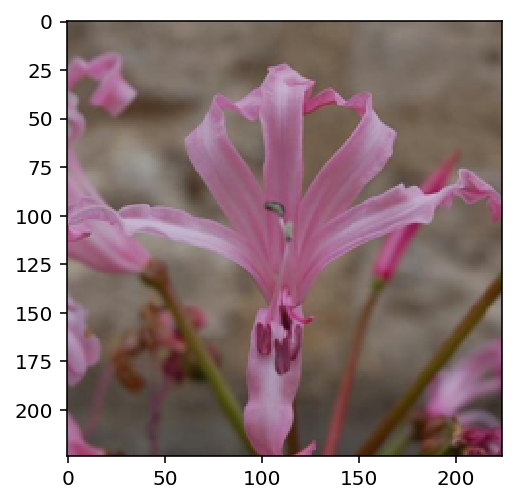

In [39]:
imshow(test_image)

In [40]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.eval()
    model.cpu()
    
    image = process_image(image_path)
    image = image.unsqueeze(0)
    output = model.forward(Variable(image, volatile=True))
    top_prob, top_labels = torch.topk(output, topk)
    top_prob = top_prob.exp()
    top_prob_arary = top_prob.data.numpy()[0]
    
    inv_class_to_idx = {v: k for k, v in model.class_to_idx.items()}
    
    top_labels_data = top_labels.data.numpy()
    top_labels_list = top_labels_data[0].tolist()  
    
    top_classes = [inv_class_to_idx[x] for x in top_labels_list]
    
    return top_prob_arary, top_classes

In [41]:
image = f'{test_dir}/37/image_03789.jpg'
probs, classes = predict(image, loaded_network)
print(probs)
print(classes)

C:\Users\miche\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


[0.98898643 0.0037318  0.00256459 0.00177893 0.00138048]
['37', '88', '84', '57', '32']


Text(0.5,0,'Probability')

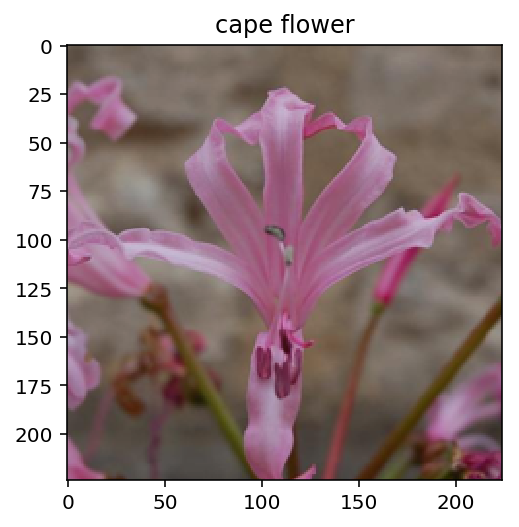

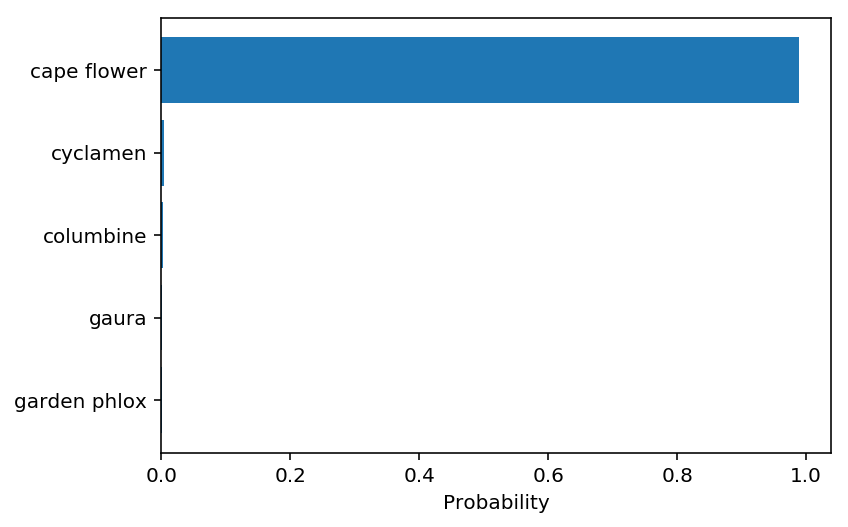

In [42]:
reversed_probs = probs[::-1]
reversed_classes = classes[::-1]

class_names = [cat_to_name[x] for x in reversed_classes]

fig, ax = plt.subplots()
image_to_show = process_image(image)
imshow(image_to_show, ax, class_names[-1])

fig, ax = plt.subplots()

y_pos = np.arange(len(class_names))


plt.barh(y_pos, reversed_probs)
plt.yticks(y_pos, class_names)
plt.xlabel('Probability')

